In [1]:
# Importing the required libraries
import tensorflow as tf
from keras import layers, models
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import random
import pandas as pd
import pyfirmata
from keras.metrics import Recall, Precision
from sklearn.metrics import f1_score
np.random.seed(42)
random.seed(42)

In [2]:
dataset_path = 'Images_Faces' # Path for our faces dataset

persons = ['jimmy', 'maya', 'moataz','mona'] 

# Arrays to store the loaded data with labels
images = []
labels_face = []
labels_emotion = []
labels_gender = []

# We will convert from our names to 0,1,2,3 using this dict
classes_indexes = {
    'jimmy':0,
    'maya':1,
    'moataz': 2,
    'mona': 3
}

In [3]:
# Augmentation parameters
rotation_angle = 20
width_shift_range = 0.2
height_shift_range = 0.2
shear_range = 0.2 # (Trimming)
zoom_range = 0.2
horizontal_flip = True

# Function to perform image augmentation using cv2
def augment_image(image):
    random_n=random.randint(1, 3) # Generate a random number 1,2 or 3
    rows, cols, _ = image.shape # Getting number of rows and cols (height and width of image)

    match random_n : # Swtiching on the random number
        case 1: # If the random number is 1
            # DO Random Rotation
            angle = np.random.uniform(-rotation_angle, rotation_angle) # Get a random angle from -20 to 20
            
            rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1) # Get the rotated matrix
            # first parameter: cols/2,rows/2 is the coordinates of the center point to make the rotation around it
            # second parameter: the randomly generated angle
            # third parameter: scaling = 1 means no scaling up or down to the image
            image  = cv2.warpAffine(image, rotation_matrix, (cols, rows))
            # Applying the random rotation on the image
            # first parameter: the image we want to rotate
            # second parameter: the rotation matrix we generated (it will be used to apply the transformation)
            # third parameter: the size of the output image must be equal to the original size (cols,rows)

        case 2:
            # Random translation (width and height shift)
            tx = np.random.uniform(-width_shift_range * cols, width_shift_range * cols)
            # tx or translation number on the x axis
            # picking a random number from -(width_shift_range*width to the) +(width_shift_range*width)
            # Example:
            # if we have cols (width) of image = 500 pixel
            # with width_shift_range = 0.2, the tx value will be a random number from -100 to 100 
            ty = np.random.uniform(-height_shift_range * rows, height_shift_range * rows)
            # same as tx but for y axis and height
            translation_matrix = np.array([[1, 0, tx], [0, 1, ty]], dtype=np.float32)
            # generating a matrix (2D array) that uses the tx and ty generated to be used in transformation
            image = cv2.warpAffine(image, translation_matrix, (cols, rows))
            # Applying the random translation on the image
            # first parameter: the image we want to rotate
            # second parameter: the translation matrix we generated (it will be used to apply the transformation)
            # third parameter: the size of the output image must be equal to the original size (cols,rows)

        case 3:
            # Random shear (trim)
            shear_value = np.random.uniform(-shear_range, shear_range)
            # Generating a random value for shearing (trimming)
            shear_matrix = np.array([[1, shear_value, 0], [0, 1, 0]], dtype=np.float32)
            # generating a matrix (2D array) that uses the shear_value generated to be used in transformation
            image = cv2.warpAffine(image, shear_matrix, (cols, rows))
            # Applying the random shear on the image
            # first parameter: the image we want to rotate
            # second parameter: the shear matrix we generated (it will be used to apply the transformation)
            # third parameter: the size of the output image must be equal to the original size (cols,rows)
            
    return image

In [4]:
# Lists to store augmented images and labels
augmented_images = []
augmented_labels_face = []
augmented_labels_emotion = []
augmented_labels_gender = []

# Iterate through your dataset
for person in persons: # For each person
    person_path = os.path.join(dataset_path, person) # Get the path of his/her images

    # Iterate over each image in the person's folder
    for filename in os.listdir(person_path):
        if filename.endswith('.jpg'): # check if it is a photo (it will always be)
            # Load image
            image_path = os.path.join(person_path, filename) # Getting the full path of the current image
            original_image = cv2.imread(image_path) # Reading it
            original_image = cv2.resize(original_image, (224, 224))  # Resize all images to match model input size (224x224)

            # Extract labels from the filename
            _, emotion, gender, _ = filename[:-4].split('-') # We don't need the name and the count so putting _
            # Explaination
            # the file name will be like maya-happy-female-4.jpg
            # [-4] removes .jpg
            # when splitting the filename on - it returns the 4 variables name emotion gender count
            # keeping only the emotion and gender

            # Convert labels to numerical             
            face_label = classes_indexes[person]  # Getting the class index for the current person
            emotion_label = 1 if emotion == 'happy' else 0  # Happy = 1, Neutral = 0
            gender_label = 1 if gender == 'female' else 0 # Female = 1, Male = 0
            
            # Adding all images without augmentation
            images.append(original_image)
            labels_face.append(face_label)
            labels_emotion.append(emotion_label)
            labels_gender.append(gender_label)
            
            # Apply augmentation to generate additional images
            augmented_image = augment_image(original_image.copy())

            # Append augmented image and labels to the lists
            # That ensures that all the images are being augmented once and added to our training data
            augmented_images.append(augmented_image)
            augmented_labels_face.append(face_label)
            augmented_labels_emotion.append(emotion_label)
            augmented_labels_gender.append(gender_label)

In [5]:
# Explaining this line :_, emotion, gender, _ = filename[:-4].split('-')
filename = "jimmy-happy-3-5.jpg" # assume this is the name of a file
print(filename[:-4].split('-')) # splitting to get the jimmy, happy, 3, 5
_, emotion, fingers_count, _ = filename[:-4].split('-') # we will not use jimmy and 5
print(emotion)
print(fingers_count)

['jimmy', 'happy', '3', '5']
happy
3


In [6]:
print(labels_gender) # Make sure it's zeros and ones

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [7]:
# We had two options for emotions and genders
# If we dealt with as a binary classification problem (only one class)
# We could have converted the y_emotion only to an ordinary numpy array [0,0,0,1,1,1,0,1,0,...]
# That will lead us to create a sigmoid output layer in the model
# But we found that the model works really better when all the features are one-hot encoded and the softmax is used not sigmoid
# So, we converted all of our three features to one-hot encoding using to_categorical method

# One Hot Encoding Example:
# if we have 4 classes, then each label will be represented as an array of size 4
# array: [0 1 0 0] means that it's a label for index 1 (a photo of maya)
# for emotion it will be of size 2 [0 1] means happy for example and so on

# Convert lists to numpy arrays
X_train = np.array(images) # Converting from python list to numpy array of cv2 images
y_face = to_categorical(labels_face,num_classes=4) # Convert to one-hot encoding because of multi-classes
y_emotion = to_categorical(labels_emotion,num_classes=2) # Convert to one-hot encoding
y_gender = to_categorical(labels_gender,num_classes=2) # Convert to one-hot encoding

# Convert augmented lists to numpy arrays
X_augmented = np.array(augmented_images) # Converting from python list to numpy array of cv2 images
y_face_augmented = to_categorical(augmented_labels_face, num_classes=4) # Convert to one-hot encoding because of multi-classes
y_emotion_augmented = to_categorical(augmented_labels_emotion,num_classes=2) # Convert to one-hot encoding
y_gender_augmented = to_categorical(augmented_labels_gender, num_classes=2) # Convert to one-hot encoding

# Combine augmented data with original data
X_combined = np.concatenate([X_train, X_augmented]) 
y_face_combined = np.concatenate([y_face, y_face_augmented])
y_emotion_combined = np.concatenate([y_emotion, y_emotion_augmented])
y_gender_combined = np.concatenate([y_gender, y_gender_augmented])


In [ ]:
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt

# Randomly choose 16 indices
random_indices = random.sample(range(len(X_combined)), 16)

# Get the corresponding images
selected_images = X_combined[random_indices]

# Convert BGR images to RGB
selected_images_rgb = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in selected_images]

# Display the selected images in a grid
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(selected_images_rgb[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [8]:
# Split the dataset into training and validation sets with 20% for validation
X_train, X_val, y_face_train, y_face_val, y_emotion_train, y_emotion_val, y_gender_train, y_gender_val = train_test_split(
    X_combined, y_face_combined, y_emotion_combined, y_gender_combined, test_size=0.2, random_state=42
)

In [9]:
print(y_face_train) # One Hot Encoding

[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]


In [10]:
# Print the shapes of the data arrays
print("X_train shape:", X_train.shape)
print("y_face_train shape:", y_face_train.shape)
print("y_emotion_train shape:", y_emotion_train.shape)
print("y_gender_train shape:", y_gender_train.shape)
print("X_val shape:", X_val.shape)
print("y_face_val shape:", y_face_val.shape)
print("y_emotion_val shape:", y_emotion_val.shape)
print("y_gender_val shape:", y_gender_val.shape)
# Training Set: includes 7705 image of size 224*224*3(BGR)
# Validation Set: includes 1927 image of size 224*224*3(BGR)

X_train shape: (7705, 224, 224, 3)
y_face_train shape: (7705, 4)
y_emotion_train shape: (7705, 2)
y_gender_train shape: (7705, 2)
X_val shape: (1927, 224, 224, 3)
y_face_val shape: (1927, 4)
y_emotion_val shape: (1927, 2)
y_gender_val shape: (1927, 2)


In [12]:
# Define the CNN backbone (shared base model)
def create_shared_cnn(input_shape):
    model = models.Sequential(name='shared_cnn')
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    return model

# Define the face recognition head
def create_face_head(shared_cnn, num_faces):
    model = models.Sequential(name='face_head')
    model.add(shared_cnn)
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(num_faces, activation='softmax', name='face_output'))
    return model

# Define the emotion classification head
def create_emotion_head(shared_cnn, num_emotions):
    model = models.Sequential(name='emotion_head')
    model.add(shared_cnn)
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu')) # We added extra layer for emotion because it had a very low accuracy
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(num_emotions, activation='softmax', name='emotion_output'))
    return model

# Define the gender detection head
def create_gender_head(shared_cnn, num_genders):
    model = models.Sequential(name='gender_head')
    model.add(shared_cnn)
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(num_genders, activation='softmax', name='gender_output'))
    return model

# Combine the shared CNN backbone with multiple heads for multi-task learning
def create_multi_task_model(input_shape, num_faces, num_emotions, num_genders):
    shared_cnn = create_shared_cnn(input_shape)
    face_head = create_face_head(shared_cnn, num_faces)
    emotion_head = create_emotion_head(shared_cnn, num_emotions)
    gender_head = create_gender_head(shared_cnn, num_genders)

    model_input = tf.keras.Input(shape=input_shape, name='input_image') # Input image to the model
     # Setting the input to all the heads
    face_output = face_head(model_input)
    emotion_output = emotion_head(model_input)
    gender_output = gender_head(model_input)

    model = models.Model(inputs=model_input, outputs=[face_output, emotion_output, gender_output]) # Combine all of the 3 heads in one

    return model


In [13]:
input_shape = (224, 224, 3)
num_faces = 4
num_emotions = 2
num_genders = 2

multi_task_model = create_multi_task_model(input_shape, num_faces, num_emotions, num_genders)

# Compile the model with appropriate loss functions for each task
multi_task_model.compile(optimizer='adam',
                         loss={'face_head': 'categorical_crossentropy',
                               'emotion_head': 'categorical_crossentropy',
                               'gender_head': 'categorical_crossentropy'},
                         metrics={'face_head': 'accuracy', 'emotion_head': 'accuracy', 'gender_head': 'accuracy'})

# Display model summary
multi_task_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 face_head (Sequential)      (None, 4)                    5983284   ['input_image[0][0]']         
                                                                                                  
 emotion_head (Sequential)   (None, 2)                    5984818   ['input_image[0][0]']         
                                                                                                  
 gender_head (Sequential)    (None, 2)                    5983250   ['input_image[0][0]']         
                                                                                              

In [14]:
gpus = tf.config.experimental.list_physical_devices('GPU') # Return all the GPUS in my device
for gpu in gpus: # For each GPU you found
    tf.config.experimental.set_memory_growth(gpu, True) # Maximize its usage

In [15]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
# Early stopping to stop whenever the validation loss increases in one epoch and set the model weights to the ones who had least val_loss


In [15]:
ep_5_es_1_history = multi_task_model.fit(X_train, 
                     {'face_head': y_face_train, 'emotion_head': y_emotion_train,'gender_head': y_gender_train},
                     validation_data=(X_val, {'face_head': y_face_val, 'emotion_head': y_emotion_val,'gender_head': y_gender_val}),
                     epochs=5,batch_size=32, callbacks=[early_stopping])


Epoch 1/5
241/241 [==============================] - 477s 2s/step - loss: 29.1095 - face_head_loss: 13.8417 - emotion_head_loss: 5.3514 - gender_head_loss: 9.9164 - face_head_accuracy: 0.8196 - emotion_head_accuracy: 0.7895 - gender_head_accuracy: 0.9072 - val_loss: 0.5501 - val_face_head_loss: 0.1799 - val_emotion_head_loss: 0.2583 - val_gender_head_loss: 0.1119 - val_face_head_accuracy: 0.9408 - val_emotion_head_accuracy: 0.8957 - val_gender_head_accuracy: 0.9689
Epoch 2/5
241/241 [==============================] - 448s 2s/step - loss: 0.3162 - face_head_loss: 0.1092 - emotion_head_loss: 0.1662 - gender_head_loss: 0.0408 - face_head_accuracy: 0.9630 - emotion_head_accuracy: 0.9316 - gender_head_accuracy: 0.9860 - val_loss: 0.4819 - val_face_head_loss: 0.1806 - val_emotion_head_loss: 0.2168 - val_gender_head_loss: 0.0844 - val_face_head_accuracy: 0.9465 - val_emotion_head_accuracy: 0.9066 - val_gender_head_accuracy: 0.9735
Epoch 3/5
241/241 [==============================] - 462s 2s/s

In [16]:
# Convert the history to a Pandas DataFrame to be used in plotting after then
history_df = pd.DataFrame(ep_5_es_1_history.history)

# Save the DataFrame to a CSV file
csv_filename = 'Early_Stopped_5(4)_epochs_model_history.csv'
history_df.to_csv(csv_filename, index=False)

In [18]:
multi_task_model.save_weights("Early_Stopped_5(4)_epochs_model_history_weights.h5")

In [19]:
multi_task_model.save("Early_Stopped_5(4)_epochs_model_history.h5")

c:\Program Files\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
multi_task_model = models.load_model("Early_Stopped_5(4)_epochs_model_history.h5")
# Loading the saved model to skip training while testing

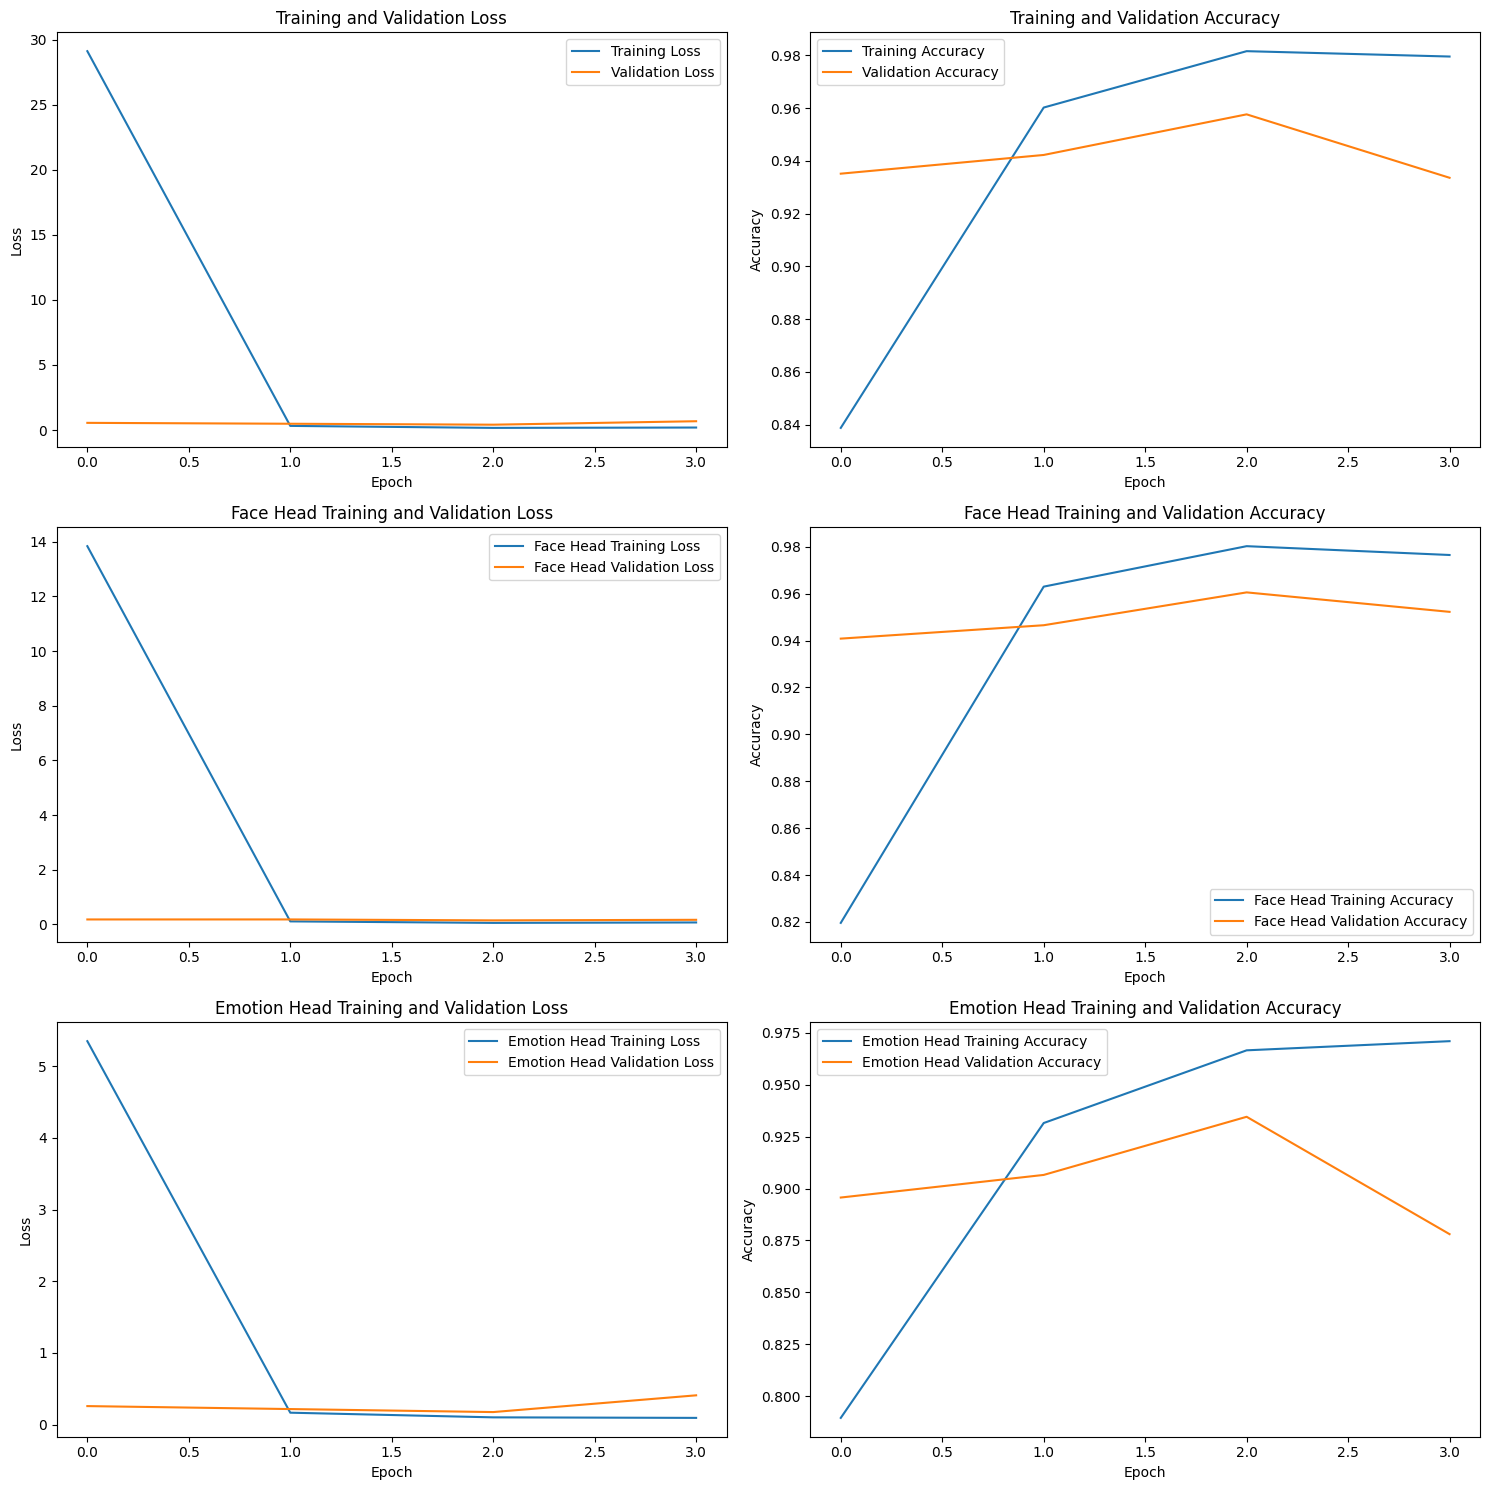

In [22]:
import pandas as pd
import matplotlib.pyplot as plt


file_path = 'Early_Stopped_5(4)_epochs_model_history.csv'
df = pd.read_csv(file_path)
df['accuracy'] = (df['face_head_accuracy']+df['emotion_head_accuracy']+df['gender_head_accuracy'])/3
df['val_accuracy'] = (df['val_face_head_accuracy']+df['val_emotion_head_accuracy']+df['val_gender_head_accuracy'])/3
# Create a figure and subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

# Plot training and validation loss
axes[0, 0].plot(df.index, df['loss'], label='Training Loss')
axes[0, 0].plot(df.index, df['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# Plot training and validation accuracy
axes[0, 1].plot(df.index, df['accuracy'], label='Training Accuracy')
axes[0, 1].plot(df.index, df['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# Plot face head loss
axes[1, 0].plot(df.index, df['face_head_loss'], label='Face Head Training Loss')
axes[1, 0].plot(df.index, df['val_face_head_loss'], label='Face Head Validation Loss')
axes[1, 0].set_title('Face Head Training and Validation Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

# Plot face head accuracy
axes[1, 1].plot(df.index, df['face_head_accuracy'], label='Face Head Training Accuracy')
axes[1, 1].plot(df.index, df['val_face_head_accuracy'], label='Face Head Validation Accuracy')
axes[1, 1].set_title('Face Head Training and Validation Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()

# Plot emotion head loss
axes[2, 0].plot(df.index, df['emotion_head_loss'], label='Emotion Head Training Loss')
axes[2, 0].plot(df.index, df['val_emotion_head_loss'], label='Emotion Head Validation Loss')
axes[2, 0].set_title('Emotion Head Training and Validation Loss')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('Loss')
axes[2, 0].legend()

# Plot emotion head accuracy
axes[2, 1].plot(df.index, df['emotion_head_accuracy'], label='Emotion Head Training Accuracy')
axes[2, 1].plot(df.index, df['val_emotion_head_accuracy'], label='Emotion Head Validation Accuracy')
axes[2, 1].set_title('Emotion Head Training and Validation Accuracy')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('Accuracy')
axes[2, 1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [3]:
face_detect = cv2.CascadeClassifier('face.xml') # loading a pretrained xml file to detect the face in the camera
# Using these arrays to map from 0,1,2,3 to our names and our emiotions
persons_index = ['Jimmy','Maya','Moataz','Mona']
emotions_index = ['Neutral','Happy']
genders_index = ['Male','Female']

In [4]:
# MediaPipe model is used for hand pose detection
import mediapipe as mp
mp_draw = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

tipIDs = [4,8,12,16,20] # IDs of the 5 fingers in the right hand (see the photo)

In [10]:
arduino = pyfirmata.Arduino('COM6') # Connecting to the arduino board

# Getting the digital pins of leds and buzzer
led_1 = arduino.get_pin('d:2:o')
led_2 = arduino.get_pin('d:3:o')
led_3 = arduino.get_pin('d:4:o')
led_4 = arduino.get_pin('d:5:o')
led_5 = arduino.get_pin('d:6:o')
buzzer = arduino.get_pin('d:10:o')

def control_led(total):
    # Controlling the leds and buzzer
    if total == 0:
        led_1.write(0)
        led_2.write(0)
        led_3.write(0)
        led_4.write(0)
        led_5.write(0)
        buzzer.write(1)
    elif total == 1:
        led_1.write(1)
        led_2.write(0)
        led_3.write(0)
        led_4.write(0)
        led_5.write(0)
        buzzer.write(0)
    elif total == 2:
        led_1.write(1)
        led_2.write(1)
        led_3.write(0)
        led_4.write(0)
        led_5.write(0)
        buzzer.write(0)
    elif total == 3:
        led_1.write(1)
        led_2.write(1)
        led_3.write(1)
        led_4.write(0)
        led_5.write(0)
        buzzer.write(0)
    elif total == 4:
        led_1.write(1)
        led_2.write(1)
        led_3.write(1)
        led_4.write(1)
        led_5.write(0)
        buzzer.write(0)
    elif total == 5:
        led_1.write(1)
        led_2.write(1)
        led_3.write(1)
        led_4.write(1)
        led_5.write(1)
        buzzer.write(0)
    else:
        led_1.write(0)
        led_2.write(0)
        led_3.write(0)
        led_4.write(0)
        led_5.write(0)
        buzzer.write(0)

def control_led2(ids):
    # Controlling the leds and buzzer
    buzzer.write(0)
    mapping = {
        4:led_1,
        8:led_2,
        12:led_3,
        16:led_4,
        20:led_5
    }
    for id in ids:
        mapping[id].write(1)
    all_ids = [4,8,12,16,20]
    for id in all_ids:
        if id in ids:
            continue
        mapping[id].write(0)


In [12]:
cap = cv2.VideoCapture(0) # Open camera
hands = mp_hands.Hands(min_detection_confidence = 0.5,min_tracking_confidence = 0.5) # Loading the hand pose detection model

while True:
    ret,image = cap.read() # Read the video from the camera, each frame is stored in the image variable
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) # converting the image from from bgr to rgb (to suit the hands model)
    image.flags.writeable = False # image must be read only before being processed by the hands model
    results = hands.process(image) # getting all the hands in the image
    image.flags.writeable = True # return the image to be writeable again
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR) # return the image bo be BGR again
    lmList = [] # List to store hand landmarks (points)
    if results.multi_hand_landmarks: # if there is a hand
        for hand_landmark in results.multi_hand_landmarks: # for each landmark (point) in the hand you found
            my_hand = results.multi_hand_landmarks[0] # detecing only one hand in the image
            for id,lm in enumerate(my_hand.landmark): # get the landmark and the id of the landmark
                h,w,c = image.shape # getting the height,width and nubmer of channels in the image
                cx,cy = int(lm.x*w), int(lm.y*h) # getting the exact location of this landmark in my image
                lmList.append([id,cx,cy]) # appending the landmark and its location in the lmList array
        mp_draw.draw_landmarks(image,hand_landmark,mp_hands.HAND_CONNECTIONS) # draw landmarks (points) on my hands

    fingers = [] # Storing the fingers shown in the image
    ids = []
    if len(lmList) != 0: # if you found a hand
        if lmList[tipIDs[0]][1] > lmList[tipIDs[0]-1][1]:
            # Check if the landmark of id = 4 location value is greater than the value of landmark of id = 3
            # that means that i have my first finger straight in the image
            ids.append(tipIDs[0]) # append the id 4 to the ids shown in the image
            fingers.append(1) # adding 1 to the fingers array
        else: # if the first finger is not straight shown
            fingers.append(0) # add 0 to the fingers array
        for id in range(1,5): # Checking for all fingers with the same method
            if lmList[tipIDs[id]][2] <  lmList[tipIDs[id]-2][2]:
                ids.append(tipIDs[id])
                fingers.append(1)
            else:
                fingers.append(0)
        total = fingers.count(1) # Counting the nubmer of ones (fingers)
        if total == 0:
            control_led(0) # open leds = total
        else:
            control_led2(ids)
        fingers_text = f"Total Fingers: {total}" # display the total fingers on the video
        cv2.putText(image, fingers_text, (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    else: # if no hands
        control_led(-1) # turn off all the leds and buzzer
    
    face = face_detect.detectMultiScale(image,1.3,5) # detect faces in the image
    if len(face)>0: # if there is a face in the image
        x,y,w,h = face[0] # get coordinates of that face
        face = image[y:y+h,x:x+w] # cropping only the face from the image
        frame_resized = cv2.resize(face, (224, 224)) # resizing the detected face
        #frame_resized = frame_resized / 255.0  # Normalize the frame (if needed)

        # Expand dimensions to make it a batch of one image
        frame_resized = np.expand_dims(frame_resized, axis=0) # face image must be in 4 dimensions to be suitable for the model predection
        # instead of 3 dimensions (width,height,number_of_channels)
        # it will be of 4 dimensions (1,width,height,number_of_channels)
        # that 1 means (you will only predict 1 face)

        # Make predictions using the model
        predictions = multi_task_model.predict(frame_resized)

        # Extract predictions for each task
        face_prediction, emotion_prediction, gender_prediction = predictions

        # face_prediction is for example:
        # [0.2 0.4 0.2 0.2] as a result from the softmax acitivation function
        # that means that it a photo of maya because she has the highest probability
        # Get the indices of the predicted classes (highest probailites)
        predicted_face_class = np.argmax(face_prediction)
        predicted_emotion_class = np.argmax(emotion_prediction)
        predicted_gender_class = np.argmax(gender_prediction)

        # Put text on the video with predicted classes
        text = f"Face Class: {persons_index[predicted_face_class]} | Emotion Class: {emotions_index[predicted_emotion_class]}"
        cv2.putText(image, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
        
        # Slightly down for gender text
        gender_text = f"Gender Class: {genders_index[predicted_gender_class]}"
        cv2.putText(image, gender_text, (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    cv2.imshow("MJ",image) # showing the video
    k = cv2.waitKey(1)
    if k == ord('q'): # quit when q is pressed
        break

cap.release() # stop recording video
cv2.destroyAllWindows() # close the video window

1/1 [==============================] - 0s 64ms/step


In [12]:
cap.release()
cv2.destroyAllWindows()